# Getting Started with Jupyter Notebook for MRI Diagnosis

This notebook will guide you through the basics of using Jupyter Notebook and set up a workflow for MRI image diagnosis using PyTorch.

In [1]:
# Check if Jupyter is installed and display its version
try:
    import notebook
    print(f"Jupyter Notebook version: {notebook.__version__}")
except ImportError:
    print("Jupyter Notebook is not installed.")

Jupyter Notebook version: 7.4.5


## Add and Run Code Cells

To add a new code cell, click the '+' button or use the menu. Enter Python code and press Shift+Enter to run the cell and see the output below it.

In [2]:
# Import required libraries for MRI diagnosis
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models 
from torch.utils.data import DataLoader, Dataset

# Set and store the random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)


## Define data transforms and load MRI datasets

In [3]:
# Set the path to the data directory
data_dir = '../data'

# Define data transformations for preprocessing MRI images
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128, 128)),
    transforms.ToTensor(), # Convert PIL images to PyTorch tensors
    # Normalize pixel values to [-1, 1] range for better model performance
    # Formula: (x - mean) / std, where mean=0.5 and std=0.5
    transforms.Normalize((0.5,), (0.5,))
])

# Load training dataset using ImageFolder, which expects data organised in folders by class (suits my data well)
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'Training'), transform=transform)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'Testing'), transform=transform) # used os equivalent to ../data/Testing

# Create data loaders for batch processing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print dataset sizes for verification
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

Number of training samples: 5712
Number of test samples: 1311


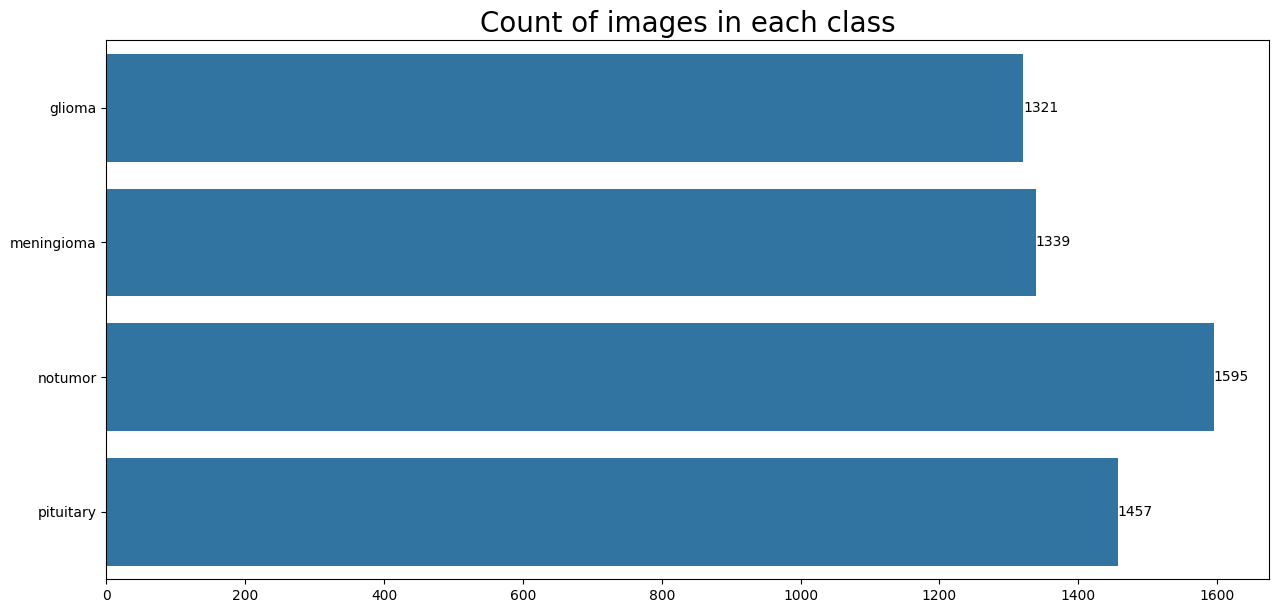

In [4]:
import seaborn as sns
import pandas as pd

# Create a DataFrame from the dataset targets
class_names = train_dataset.classes
target_counts = pd.DataFrame({
	'Class': [class_names[i] for i in train_dataset.targets],
})

# Count of images in each class in train data
plt.figure(figsize=(15,7))
ax = sns.countplot(data=target_counts, y='Class')

plt.xlabel('')
plt.ylabel('')
plt.title('Count of images in each class', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

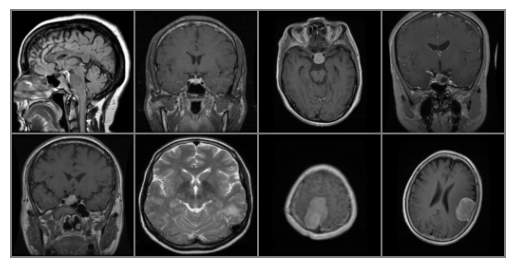

Labels: [2 3 3 3 3 2 1 1]


In [5]:
import torchvision  # Import torchvision for image utilities

# Visualise a batch of MRI images
def imshow(img):
    img = img * 0.5 + 0.5  # Undo normalisation to bring pixel values back to [0, 1] for display
    npimg = img.numpy()  # Convert the tensor to a NumPy array
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray') # Change (channels, height, width) to (height, width, channels) for matplotlib
    plt.axis('off')
    plt.show()

# Get a batch of training data (images and labels)
images, labels = next(iter(train_loader))

# Show a grid of the first 8 images in the batch
imshow(torchvision.utils.make_grid(images[:8], nrow=4))
print('Labels:', labels[:8].numpy())  # label = data class

In [6]:
# Define an improved CNN model for MRI classification with Dropout and extra Dense layer

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.2),  # Dropout after first pooling
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3),  # Dropout after second pooling
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 32 * 32, 256),
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout before dense layers
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

num_classes = len(train_dataset.classes)
model = SimpleCNN(num_classes)
print(model)

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.3, inplace=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=32768, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.3, inplace=False)
    (7): Linear(in_features=128, out_features=4, bias=True)
  )
)


## Set up loss function, optimizer, and device

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Training loop

In [8]:
epochs = 12
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

Epoch 1/12, Loss: 0.9063
Epoch 2/12, Loss: 0.4910
Epoch 3/12, Loss: 0.3634
Epoch 4/12, Loss: 0.3048
Epoch 5/12, Loss: 0.2496
Epoch 6/12, Loss: 0.1893
Epoch 7/12, Loss: 0.1813
Epoch 8/12, Loss: 0.1484
Epoch 9/12, Loss: 0.1393
Epoch 10/12, Loss: 0.1144
Epoch 11/12, Loss: 0.0961
Epoch 12/12, Loss: 0.1007


In [9]:
# Evaluate the model on the test set

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')

Test Accuracy: 96.41%


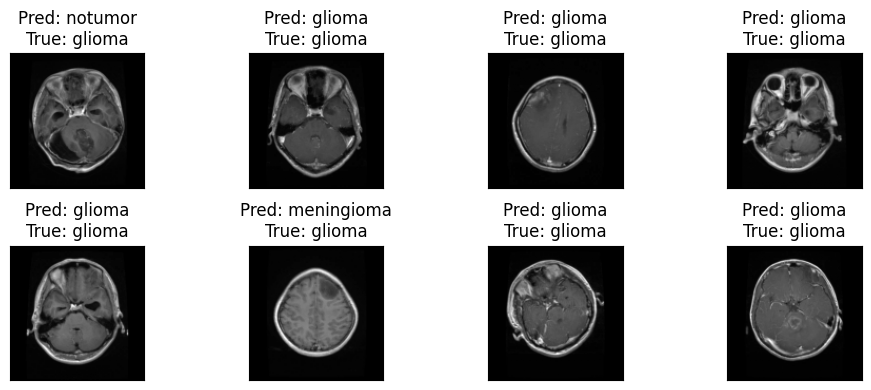

In [10]:
# Visualize predictions on a few test images

dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, preds = torch.max(outputs, 1)

fig = plt.figure(figsize=(10, 4))
for idx in range(8):
    ax = fig.add_subplot(2, 4, idx+1, xticks=[], yticks=[])
    img = images[idx].cpu().numpy().squeeze()
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Pred: {train_dataset.classes[preds[idx]]}\nTrue: {train_dataset.classes[labels[idx]]}")
plt.tight_layout()
plt.show()

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Function to convert image data to flat features
def get_flat_data(dataloader):
    all_features = []
    all_labels = []
    for images, labels in dataloader:
        # Flatten the images (1x128x128 -> 16384)
        features = images.view(images.size(0), -1).numpy()
        all_features.append(features)
        all_labels.append(labels.numpy())
    return np.vstack(all_features), np.concatenate(all_labels)

# Get flattened training and test data
X_train, y_train = get_flat_data(train_loader)
X_test, y_test = get_flat_data(test_loader)

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_pred)

# Train Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_pred)

# Print comparison
print("Model Accuracy Comparison:")
print(f"CNN Model: {accuracy:.2f}%")
print(f"Random Forest: {rf_accuracy*100:.2f}%")
print(f"Logistic Regression: {lr_accuracy*100:.2f}%")

# Print detailed classification report for each model
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, rf_pred, target_names=class_names))

print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, lr_pred, target_names=class_names))

Model Accuracy Comparison:
CNN Model: 96.41%
Random Forest: 93.44%
Logistic Regression: 90.01%

Random Forest Classification Report:
              precision    recall  f1-score   support

      glioma       0.95      0.84      0.89       300
  meningioma       0.85      0.91      0.88       306
     notumor       0.97      1.00      0.99       405
   pituitary       0.96      0.97      0.96       300

    accuracy                           0.93      1311
   macro avg       0.93      0.93      0.93      1311
weighted avg       0.94      0.93      0.93      1311


Logistic Regression Classification Report:
              precision    recall  f1-score   support

      glioma       0.87      0.79      0.83       300
  meningioma       0.81      0.82      0.81       306
     notumor       0.96      1.00      0.98       405
   pituitary       0.94      0.96      0.95       300

    accuracy                           0.90      1311
   macro avg       0.89      0.89      0.89      1311
weighted

## Experimenting with accuracy

Increasing epochs to 10 resulted in higher accuracy and lower test loss.

code below shows more complex CNN and incorperating a pretrained model. Accuracy resulted in 97.18% and test loss of 0.047

In [12]:
# Define a transfer learning model inspired by Keras Xception example
from torchvision import models
import torch.nn.functional as F

# Use a pretrained model as feature extractor (e.g., ResNet18, since Xception is not in torchvision)
img_shape = (128, 128)  # Our images are resized to 128x128, 1 channel
base_model = models.resnet18(weights='IMAGENET1K_V1')
base_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # Adapt for grayscale
num_ftrs = base_model.fc.in_features
base_model.fc = nn.Identity()  # Remove the original classification head

# Optionally freeze base model layers (uncomment to freeze)
# for param in base_model.parameters():
#     param.requires_grad = False

class TransferCNN(nn.Module):
    def __init__(self, num_classes):
        super(TransferCNN, self).__init__()
        self.base = base_model
        self.flatten = nn.Flatten()
        self.dropout1 = nn.Dropout(0.3)
        self.fc1 = nn.Linear(num_ftrs, 128)
        self.dropout2 = nn.Dropout(0.25)
        self.fc2 = nn.Linear(128, num_classes)
    def forward(self, x):
        x = self.base(x)
        x = self.flatten(x)
        x = self.dropout1(x)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

num_classes = len(train_dataset.classes)
model = TransferCNN(num_classes)
print(model)

TransferCNN(
  (base): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru